#Diffussion probabilistic models implementation day--ahead energy price generation

This code follows the one at https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html

The reference paper is
@misc{ho2020denoisingdiffusionprobabilisticmodels,
      title={Denoising Diffusion Probabilistic Models},
      author={Jonathan Ho and Ajay Jain and Pieter Abbeel},
      year={2020},
      eprint={2006.11239},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/2006.11239},
}

Data sources:
https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/SFTP%20guide.html

Folder -> EnergyPrices_12.1.D_r3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/torch_Training_Vanilla_Diffussion/"
os.makedirs(save_dir, exist_ok=True)

read_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/"

Mounted at /content/drive


In [4]:
# DEPENDENCIES
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
import seaborn as sns
import itertools
import time
import os

from scipy import stats


In [5]:
file_paths = [
    os.path.join(read_dir, 'France (FR)2022.csv')
    #os.path.join(read_dir, 'France (FR)2023.csv')
    #os.path.join(read_dir, 'France (FR)2024.csv')
]

data_frames = []

for file_path in file_paths:
    data_frames.append(pd.read_csv(file_path, sep=","))

data = pd.concat(data_frames, ignore_index=True)
# Display the first few rows of the combined DataFrame
print(data.head())

Hour_values = ['00:00', '01:00', '02:00', '03:00',
       '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00',
       '20:00', '21:00', '22:00', '23:00']

Initial_data = data[Hour_values].to_numpy()

    Date(UTC) AreaDisplayName   00:00   01:00   02:00   03:00   04:00   05:00  \
0  2022-01-01     France (FR)   78.48   85.16   50.00   37.67   39.70   40.59   
1  2022-01-02     France (FR)   52.59   48.97   34.94   29.56   33.97   34.52   
2  2022-01-03     France (FR)    1.71    1.24    0.06    0.09    1.44   41.11   
3  2022-01-04     France (FR)  115.55  113.29  105.81  105.00  115.11  156.91   
4  2022-01-05     France (FR)  105.10   84.50   75.38   79.11   94.79  169.04   

    06:00   07:00  ...   14:00   15:00   16:00   17:00   18:00   19:00  \
0   43.26   49.66  ...   98.52  114.50  149.97  146.33  140.28  121.88   
1   41.80   48.95  ...   39.30   40.79   47.91   65.09   67.85   62.22   
2   90.54  161.79  ...  112.87  126.80  148.49  175.06  180.00  146.43   
3  182.64  178.91  ...  180.93  166.69  189.88  184.94  178.99  156.12   
4  215.98  211.13  ...  200.00  206.07  242.10  265.00  265.00  241.93   

    20:00   21:00   22:00   23:00  
0  102.61   97.46   85.16   57.0

In [6]:
def normalize_column_minmax(column):
    min_price = column.min()
    max_price = column.max()
    normalized_column = (column - min_price) / (max_price - min_price)

    # Store normalization parameters
    normalization_params_minmax[column.name] = {'min_price': min_price, 'max_price': max_price}

    return normalized_column

# Dictionary to store normalization parameters
normalization_params_minmax = {}

normalized_data_minmax = data[Hour_values].apply(normalize_column_minmax, axis=0)

normalization_params_minmax_df = pd.DataFrame.from_dict(normalization_params_minmax, orient='index')

data_normalized_minmax = data.copy()
data_normalized_minmax[Hour_values] = normalized_data_minmax

In [7]:
if data_normalized_minmax[Hour_values].isna().any().any():
    print("⚠️ ALERT: One or more columns in Hour_values contain NaN values!")
else:
    print("✅ All columns in Hour_values are free of NaN values.")

Training_data = data_normalized_minmax[Hour_values].to_numpy()
print('Training_data.shape ', Training_data.shape)

✅ All columns in Hour_values are free of NaN values.
Training_data.shape  (365, 24)


In [8]:
# Dictionary to store normalization parameters
normalization_mstd_params = {}

# Function to normalize a column using mean and standard deviation
def normalize_mstd_column(column):
    mean = column.mean()
    std = column.std()
    normalized_column = (column - mean) / std

    # Store normalization parameters
    normalization_mstd_params[column.name] = {'mean': mean, 'std': std}

    return normalized_column

# Apply normalization to the specified columns
normalized_mstd_data = data[Hour_values].apply(normalize_mstd_column, axis=0)

normalization_mstd_params_df = pd.DataFrame.from_dict(normalization_mstd_params, orient='index')

data_normalized_mstd = data.copy()
data_normalized_mstd[Hour_values] = normalized_mstd_data

torch.Size([365, 24])


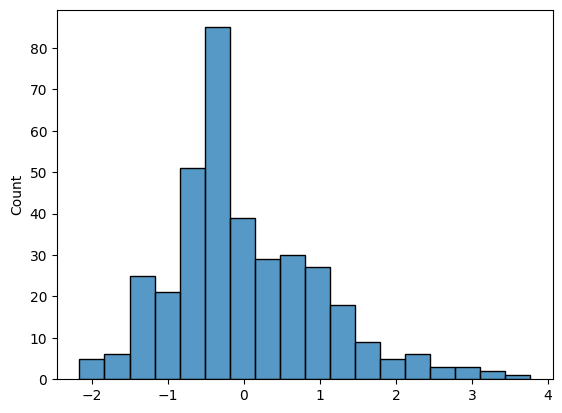

In [9]:
# Hyperparameters
TIME_STEPS = 250
BETA = 0.02
input_dim = 24 # 24-hour prices for a day
epochs = 5*10**3

# Create training dataset
dataset = torch.tensor(data_normalized_mstd[Hour_values].to_numpy()).float()
#dataset = torch.tensor(data_normalized[Hour_values].to_numpy()).float()          #More expensive to train
#dataset = torch.tensor(Initial_data).float()         #Exploiting gradients here!
print(dataset.shape)

sns.histplot(dataset[:, 0])
plt.show()

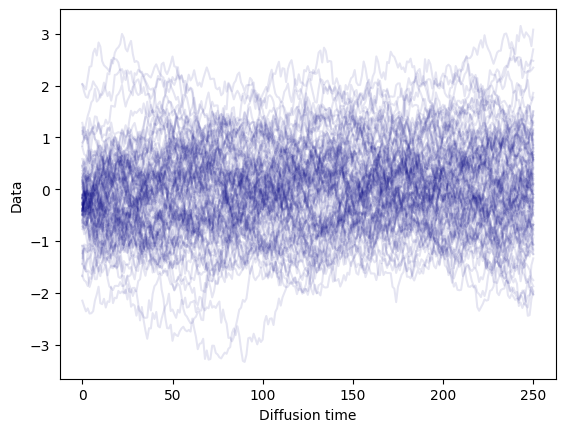

In [10]:
#--------------------------------------------------------------------------------------------#
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion following equation 2
    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            torch.sqrt(torch.tensor(1 - beta)) * xt,
            torch.sqrt(torch.tensor(beta)) * torch.ones_like(xt)
        )
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

#--------------------------------------------------------------------------------------------#
_, samples = do_diffusion(dataset)

for t in torch.stack([samples[j][:100,0] for j in range(len(samples))])[:,:].T:
    plt.plot(t, c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

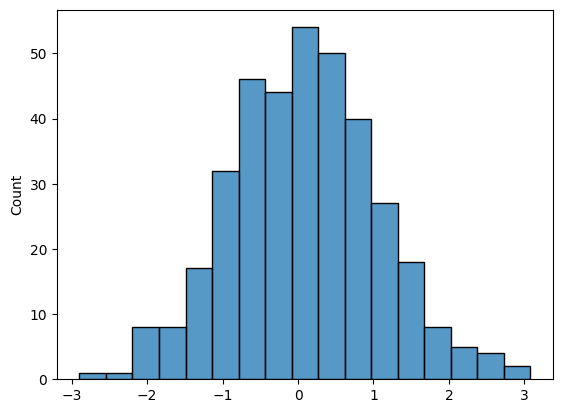

Statistic: 0.9976748484442629, p-value: 0.8945257623033664
The data (may) follows a normal distribution (fail to reject H0).


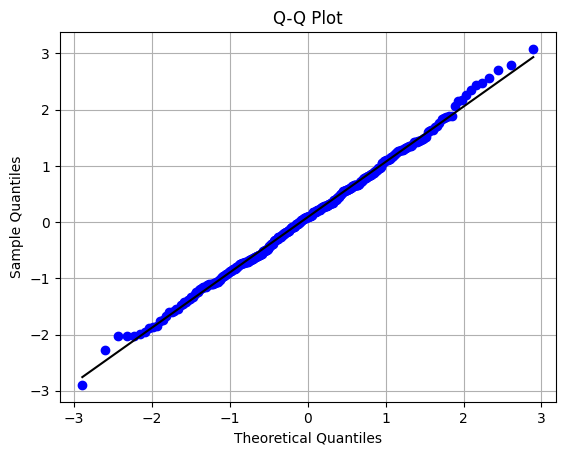

In [11]:
sns.histplot(samples[-1][:,0])
plt.show()

#Check enough diffussion has been added so that X_T looks N(0,1)
# Shapiro-Wilk test
stat, p_value = stats.shapiro(samples[-1][:,0])

print(f"Statistic: {stat}, p-value: {p_value}")

alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data (may) follows a normal distribution (fail to reject H0).")
else:
    print("The data does NOT follow a normal distribution (reject H0).")

# Generate a Q-Q plot
fig, ax = plt.subplots()
stats.probplot(samples[-1][:, 0].numpy(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('black')  # Reference line color
ax.set_title('Q-Q Plot')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [12]:
#--------------------------------------------------------------------------------------------#
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # compute the (plain) loss in equation 3, no improvements yet

    # loss for x(T)
    p = torch.distributions.Normal(
        torch.zeros_like(forward_samples[0]),
        torch.ones_like(forward_samples[0])
    )
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )

        # normalize t between 0 and 1 and add it as a new column
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0],1)),
            dim=1
        )
        # compute p( x(t-1) | x(t) )
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.Normal(mu, sigma)

        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))

    return loss / len(forward_samples)
#--------------------------------------------------------------------------------------------#
## NN parametrization of $\mu$ and $\Sigma$ of the reversed process in equation 1
mean_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim + 1, 32), torch.nn.ReLU(),
    torch.nn.Linear(32, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, input_dim)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim + 1, 32), torch.nn.ReLU(),
    torch.nn.Linear(32, 16), torch.nn.Tanh(),
    torch.nn.Linear(16, input_dim), torch.nn.Softplus()
)

#--------------------------------------------------------------------------------------------#
def train(mean_model, var_model, dataset, epochs):
  optim = torch.optim.AdamW(itertools.chain(mean_model.parameters(), var_model.parameters()),
                            lr=1e-2, weight_decay=1e-6,
                            )
  loss_history = []

  start_time = time.time()  # Start the timer
  for epoch in range(epochs):
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(forward_distributions, forward_samples, mean_model, var_model)
    loss.backward()
    optim.step()

    # Calculate elapsed time
    elapsed_time = int(time.time() - start_time)
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    elapsed_time_str = f"{hours:02}:{minutes:02}:{seconds:02}"  # Format hh:mm:ss

    # Calculate percentage completion
    percentage = (epoch + 1) / epochs * 100
    print(f"\rLoss: {loss:.4f}: Training: {percentage:.0f}% - Elapsed Time: {elapsed_time_str}", end='')

    loss_history.append(loss.item())

  return loss_history

Loss: 0.5130: Training: 100% - Elapsed Time: 01:01:39✅


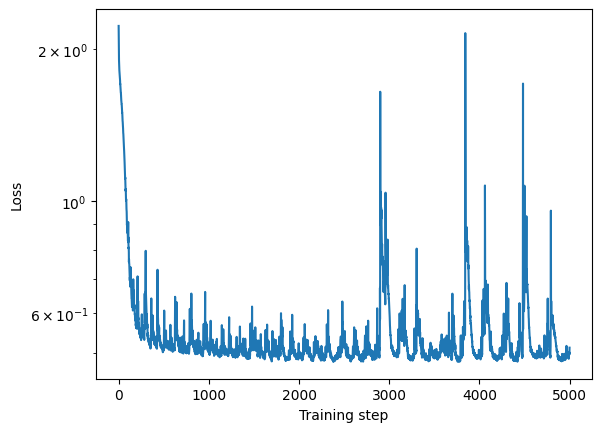

In [13]:
loss_history = train(mean_model, var_model, dataset, epochs)
print('✅')

plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

In [14]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
  # perform reverse process following equation 1, where $\mu$ and $\Sigma$ are the NN parametrizations after training
    p = torch.distributions.Normal(torch.zeros(count, input_dim), torch.ones(count, input_dim))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape[0], 1) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

samps = torch.stack(sample_reverse(mean_model, var_model, 365))
samps.shape

torch.Size([251, 365, 24])

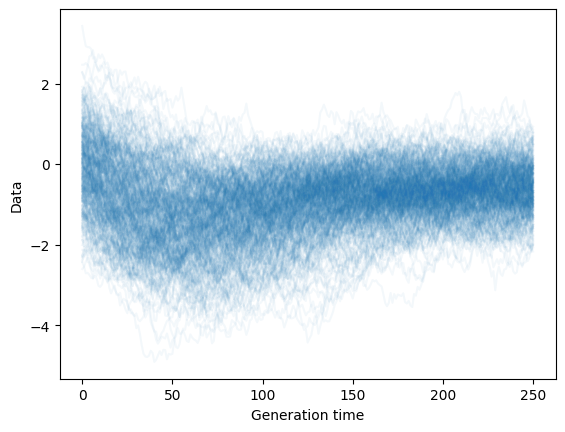

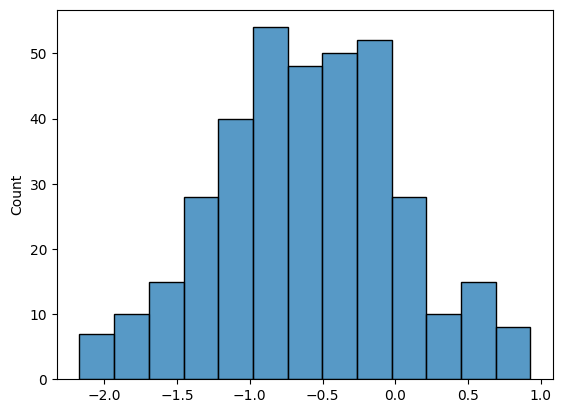

In [15]:
for t in samps[:, :, 0].T:
    plt.plot(t, color='C0', alpha=0.05)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

#Denoissed distribution
sns.histplot(samps[-1, :, 0])
plt.show()

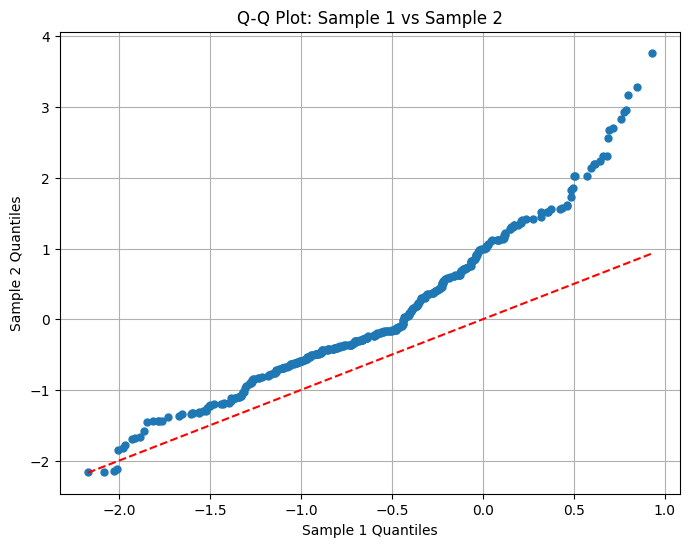

In [16]:
# Sort the samples
sorted_sample1 = np.sort(samps[-1, :, 0].numpy())
sorted_sample2 = np.sort((data_normalized_mstd[Hour_values].to_numpy())[:,0])

# Interpolate if sample sizes are unequal
if len(sorted_sample1) != len(sorted_sample2):
    min_len = min(len(sorted_sample1), len(sorted_sample2))
    max_len = max(len(sorted_sample1), len(sorted_sample2))
    if len(sorted_sample1) == min_len:
        sorted_sample1 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), sorted_sample1)
    else:
        sorted_sample2 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), sorted_sample2)

# Create Q-Q plot
plt.figure(figsize=(8, 6))
plt.plot(sorted_sample1, sorted_sample2, 'o', markersize=5)
plt.plot([min(sorted_sample1), max(sorted_sample1)], [min(sorted_sample1), max(sorted_sample1)], 'r--')  # Reference line
plt.xlabel('Sample 1 Quantiles')
plt.ylabel('Sample 2 Quantiles')
plt.title('Q-Q Plot: Sample 1 vs Sample 2')
plt.grid(True)
plt.show()


In [17]:
# Define save paths for the generator and discriminator
mean_model_save_path = os.path.join(save_dir, "mean_model.pth")
var_model_save_path = os.path.join(save_dir, "var_model.pth")

# Save the generator and discriminator models
torch.save(mean_model, mean_model_save_path)
torch.save(var_model, var_model_save_path)

file_path = os.path.join(save_dir, "loss_history.txt")
with open(file_path, "w") as file:
    # Convert each number to string and join them with commas
    file.write(", ".join(map(str, loss_history)))